In [28]:
import pandas as pd
import matplotlib as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
from numpy.ma.core import ceil
from scipy.spatial import distance #distance calculation
from sklearn.preprocessing import MinMaxScaler #normalisation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score #scoring
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib import animation, colors
from collections import Counter
import random
import joblib

# Helper functions

# Data Normalisation
def minmax_scaler(data):
  scaler = MinMaxScaler()
  scaled = scaler.fit_transform(data)
  return scaled

# Euclidean distance
def e_distance(x,y):
  return distance.euclidean(x,y)

# Manhattan distance
def m_distance(x,y):
  return distance.cityblock(x,y)


## Degree of Belonging
def winning_neuron(data, t, som, num_rows, num_cols):
    winner = [0, 0]
    shortest_distance = np.sqrt(data.shape[1])  # initialize with max distance
    input_data = data[t]
    for row in range(num_rows):
        for col in range(num_cols):
            distance = e_distance(som[row][col], input_data)
            if distance < shortest_distance:
                shortest_distance = distance
                winner = [row, col]
    
    return winner, shortest_distance

def winning_neuron_per_rasa(data, t, som, num_rows, num_cols, label_map, rasa):
    winner = [0, 0]
    shortest_distance = np.sqrt(data.shape[1])  # initialize with max distance
    input_data = data[t]
    for row in range(num_rows):
        for col in range(num_cols):
            if label_map[row][col] == rasa:
                distance = e_distance(som[row][col], input_data)
                if distance < shortest_distance:
                    shortest_distance = distance
                    winner = [row, col]
    
    return winner, shortest_distance

def get_shortest_distances_per_rasa(data, t, som, num_rows, num_cols, num_classes, label_map):
    df = {}
    for rasa in range(1,num_classes+1):
        winner, shortest_distance = winning_neuron_per_rasa(data, t, som, num_rows, num_cols, label_map, rasa)
        df[rasa] = shortest_distance
    winner, shortest_distance = winning_neuron(data, t, som, num_rows, num_cols)
    row = winner[0]
    col = winner[1]
    df["Predicted"] = label_map[row][col]
    return label_map[row][col], df


# Learning rate and neighbourhood range calculation
def decay(step, max_steps,max_learning_rate,max_m_dsitance):
  coefficient = 1.0 - (np.float64(step)/max_steps)
  learning_rate = coefficient*max_learning_rate
  neighbourhood_range = ceil(coefficient * max_m_dsitance)
  return learning_rate, neighbourhood_range

In [35]:
### MODIFY THE NAME OF YOUR CSV HERE
df_data = pd.read_csv('y.csv')
y = df_data['Navarasa']
columns_to_drop = ['data_set_id', 'Cluster', 'Srno', 'Belonging to C-0', 'Belonging to C-1', 'Navarasa', 'sno']

# extra_features_to_drop = ['Magnitude Spectrum Overall Standard Deviation', 'Magnitude Spectrum Overall Average',
# 						  'Power Spectrum Overall Standard Deviation', 'Power Spectrum Overall Average',
# 						  'FFT Bin Frequency Labels Overall Average', 'Beat Histogram Overall Standard Deviation',
# 						  'Log of ConstantQ Overall Average', 'Spectral Centroid Overall Standard Deviation',
# 						  'Peak Detection Overall Standard Deviation', 'Derivative of Method of Moments Overall Average', 'Derivative of Running Mean of Method of Moments Overall Average']

# 11 / 13
extra_features_to_drop = ['Magnitude Spectrum Overall Average','Power Spectrum Overall Standard Deviation', 'Power Spectrum Overall Average',
						   'Spectral Centroid Overall Standard Deviation','Derivative of Method of Moments Overall Average', 'Derivative of Running Mean of Method of Moments Overall Average']

# 12 / 13
extra_features_to_drop = ['Magnitude Spectrum Overall Standard Deviation', 'Magnitude Spectrum Overall Average',
						  'Power Spectrum Overall Standard Deviation', 'Power Spectrum Overall Average',
						  'FFT Bin Frequency Labels Overall Average', 'Beat Histogram Overall Standard Deviation',
						  'Log of ConstantQ Overall Average', 'Spectral Centroid Overall Standard Deviation', 'Peak Detection Overall Standard Deviation']

# 12/13
extra_features_to_drop = ['Derivative of Method of Moments Overall Average', 'Derivative of Running Mean of Method of Moments Overall Average', 'Log of ConstantQ Overall Average']

red_marked_features = ['Standard Deviation of Beat Sum Overall Average', 'Area Method of Moments Overall Standard Deviation', 'Derivative of Area Method of Moments Overall Standard Deviation', 'Running Mean of Area Method of Moments Overall Standard Deviation',
					   'Standard Deviation of Area Method of Moments Overall Standard Deviation', 'Derivative of Running Mean of Area Method of Moments Overall Standard Deviation', 'Derivative of Standard Deviation of Area Method of Moments Overall Standard Deviation',
					   'Standard Deviation of Compactness Overall Average', 'Standard Deviation of Beat Sum Overall Average', 'Standard Deviation of Strongest Frequency Via Zero Crossings Overall Average', 'Standard Deviation of Strongest Frequency Via Spectral Centroid Overall Average',
					   'Standard Deviation of Strongest Frequency Via FFT Maximum Overall Average', 'Method of Moments Overall Average', 'Running Mean of Method of Moments Overall Average', 'Standard Deviation of Method of Moments Overall Average',
					   'Derivative of Standard Deviation of Method of Moments Overall Average', 'Area Method of Moments Overall Average', 'Derivative of Area Method of Moments Overall Average', 'Running Mean of Area Method of Moments Overall Average',
					   'Standard Deviation of Area Method of Moments Overall Average', 'Derivative of Running Mean of Area Method of Moments Overall Average', 'Derivative of Standard Deviation of Area Method of Moments Overall Average',
					   ]

for f in red_marked_features:
	if f in df_data.columns.tolist():
		print("remove this:", f)

# extra_features_to_drop = ['Spectral Centroid Overall Standard Deviation']

# removing 'Spectral Centroid Overall Standard Deviation' feature is significantly improving accuracy
df_data = df_data.drop(columns=columns_to_drop, axis=1)
df_data = df_data.drop(columns=extra_features_to_drop, axis=1)



df_data = df_data.dropna(axis=1)  # Drop rows with NaN in any column
df_data = df_data.loc[:, (df_data != 0).any(axis=0)]  # Drop rows with zero in any column
column_list = df_data.columns.values.tolist()
##### MODIFY HERE BASED ON YOUR DATA COLOUMNS AND LABEL COLUMNS
#Extract x and y from the dataframe
X = df_data.iloc[:,0:253].values
y = y.values
# print(X)
# print(y)

print("Column names:", df_data.columns.tolist())
print("MAMAAA:",  len(X))

print(len(X[0]))
# print(X[0])
X_std = X
# Standardize data
Scaler = StandardScaler().fit(X)
X_std = Scaler.transform(X)
joblib.dump(Scaler, 'scaler.pkl')
print(X)
print("Standard:")
print(X_std)
print(len(X_std))

print(df_data.columns.tolist()[33:36])

# print(X_std.shape)

# #applying PCA 
# model = PCA(n_components=60).fit(X_std)
# X_pc = model.transform(X_std)

# # number of components
# n_pcs= model.components_.shape[0]

train_x, test_x, train_y, test_y = train_test_split(X_std, y, test_size=0.2, random_state=42)
# print(train_x.shape, train_y.shape, test_x.shape, test_y.shape) # check the shapes

Column names: ['Magnitude Spectrum Overall Standard Deviation', 'Power Spectrum Overall Standard Deviation', 'Spectral Centroid Overall Standard Deviation', 'Zero Crossings Overall Standard Deviation', 'Derivative of Zero Crossings Overall Standard Deviation', 'Standard Deviation of Zero Crossings Overall Standard Deviation', 'Derivative of Running Mean of Zero Crossings Overall Standard Deviation', 'Derivative of Standard Deviation of Zero Crossings Overall Standard Deviation', 'Beat Histogram Overall Standard Deviation', 'Strongest Beat Overall Standard Deviation', 'Derivative of Strongest Beat Overall Standard Deviation', 'Running Mean of Strongest Beat Overall Standard Deviation', 'Derivative of Running Mean of Strongest Beat Overall Standard Deviation', 'Beat Sum Overall Standard Deviation', 'Derivative of Beat Sum Overall Standard Deviation', 'Running Mean of Beat Sum Overall Standard Deviation', 'Derivative of Running Mean of Beat Sum Overall Standard Deviation', 'Standard Devia

In [30]:
# # get the index of the most important feature on EACH component i.e. largest absolute value
# # using LIST COMPREHENSION HERE
# most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

# initial_feature_names = column_list

# # get the names
# most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# # using LIST COMPREHENSION HERE AGAIN
# dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}
# names_of_imp_features = my_list = list(dic.values())

# #Extracting PCA relavent features into a dataframe
# pca_df = df_data[names_of_imp_features].copy()

# X_pca = pca_df.iloc[:,:].values
# X_std_p = StandardScaler().fit_transform(X_pca)
# ##### For SOM ######
# # train and test split'

# train_x, test_x, train_y, test_y = train_test_split(X_std_p, y, test_size=0.2, random_state=42)
# print(train_x.shape, train_y.shape, test_x.shape, test_y.shape) # check the shapes

In [31]:
#### MODIFY HERE TO CHANGE THE PARAMETS OF SOM

# The training may not succeed if the shape of the topological map is not relevant to the distribution of data points in the latent space.
# Though we used a square grid in our example, we must design the map’s formation carefully. 
# One of the recommendable approaches is to use the ratio of the explained variances from the first two principal components of PCA. 
# However, if time allows, it is worth trying the different hyperparameters for fine tuning

# Parameters
num_rows = 12
num_cols = 12
max_m_distance = 4
max_learning_rate = 0.4
max_steps = int(3*10e3)

# X_norm = minmax_scaler(X_std)

# initialising self-organising map
num_dims = X_std.shape[1] # numnber of dimensions in the input data
np.random.seed(40)
# som = np.random.random_sample(size=(num_rows, num_cols, num_dims)) # map construction
som = np.zeros((num_rows, num_cols, num_dims))
# start training iterations
for step in range(max_steps):
  activation_list = random.sample(range(0,num_rows+num_cols),int((num_rows+num_cols)/1.3))
  # print(activation_list)
  if (step+1) % 1000 == 0:
    print("Iteration: ", step+1) # print out the current iteration for every 1k
  learning_rate, neighbourhood_range = decay(step, max_steps,max_learning_rate,max_m_distance)

  t = np.random.randint(0,high=X_std.shape[0]) # random index of traing data
  winner,shortest_distance = winning_neuron(X_std, t, som, num_rows, num_cols)
  for row in range(num_rows):
    for col in range(num_cols):
      # if (row+col) in activation_list:

      #   # print("hi")
      #   continue

      if m_distance([row,col],winner) <= neighbourhood_range:
        som[row][col] += learning_rate*(X_std[t]-som[row][col]) # update neighbour's weight

print("SOM training completed")


Iteration:  1000
Iteration:  2000
Iteration:  3000
Iteration:  4000
Iteration:  5000
Iteration:  6000
Iteration:  7000
Iteration:  8000
Iteration:  9000
Iteration:  10000
Iteration:  11000
Iteration:  12000
Iteration:  13000
Iteration:  14000
Iteration:  15000
Iteration:  16000
Iteration:  17000
Iteration:  18000
Iteration:  19000
Iteration:  20000
Iteration:  21000
Iteration:  22000
Iteration:  23000
Iteration:  24000
Iteration:  25000
Iteration:  26000
Iteration:  27000
Iteration:  28000
Iteration:  29000
Iteration:  30000
SOM training completed


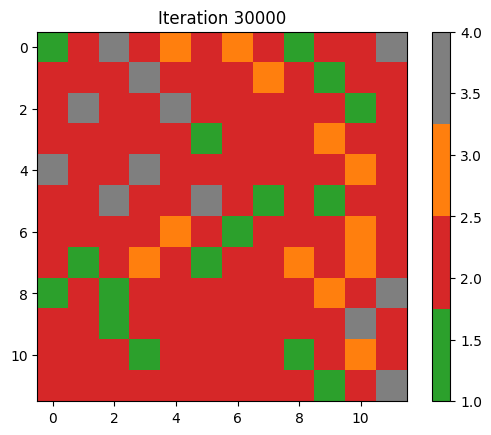

[[1 2 4 2 3 2 3 2 1 2 2 4]
 [2 2 2 4 2 2 2 3 2 1 2 2]
 [2 4 2 2 4 2 2 2 2 2 1 2]
 [2 2 2 2 2 1 2 2 2 3 2 2]
 [4 2 2 4 2 2 2 2 2 2 3 2]
 [2 2 4 2 2 4 2 1 2 1 2 2]
 [2 2 2 2 3 2 1 2 2 2 3 2]
 [2 1 2 3 2 1 2 2 3 2 3 2]
 [1 2 1 2 2 2 2 2 2 3 2 4]
 [2 2 1 2 2 2 2 2 2 2 4 2]
 [2 2 2 1 2 2 2 2 1 2 3 2]
 [2 2 2 2 2 2 2 2 2 1 2 4]]
[[[ 1.44487543e+00  1.66955188e+00  8.66501306e-01 ...  6.43869338e-01
    7.17819375e-01 -1.37465364e+00]
  [ 1.14868836e+00  1.32938287e+00  1.13208607e+00 ...  8.12335480e-01
    5.46855724e-01 -1.10102949e+00]
  [-6.01558483e-01 -7.05629915e-01  2.75012425e+00 ...  1.79933777e+00
   -5.11422994e-01  4.32106459e-01]
  ...
  [ 1.13336180e+00  1.11876897e+00 -1.07682511e-01 ... -2.16087150e-01
   -1.02425352e+00  1.89062214e-01]
  [ 1.46685787e+00  1.19018455e+00  7.05932812e-01 ...  1.24128688e-01
   -2.95745649e-01  3.14744283e-01]
  [ 1.46724537e+00  1.19002024e+00  7.10030516e-01 ...  1.23577962e-01
   -2.94757230e-01  3.15453830e-01]]

 [[ 1.44487543e+00  1.669

In [32]:
# collecting labels

label_data = y
map = np.empty(shape=(num_rows, num_cols), dtype=object)

for row in range(num_rows):
  for col in range(num_cols):
    map[row][col] = [] # empty list to store the label

for t in range(X_std.shape[0]):
  if (t+1) % 1000 == 0:
    print("sample data: ", t+1)
  winner, shortest_distance = winning_neuron(X_std, t, som, num_rows, num_cols)
  map[winner[0]][winner[1]].append(label_data[t]) # label of winning neuron

  # construct label map
label_map = np.zeros(shape=(num_rows, num_cols),dtype=np.int64)
for row in range(num_rows):
  for col in range(num_cols):
    label_list = map[row][col]
    if len(label_list)==0:
      label = 2
    else:
      label = max(label_list, key=label_list.count)
    label_map[row][col] = label

title = ('Iteration ' + str(max_steps))
# for rasa data
cmap = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange','tab:gray'])
# for indina data
# cmap = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange','tab:gray','tab:blue','tab:cyan','tab:white','tab:yellow','tab:black','tab:violet'])
plt.imshow(label_map, cmap=cmap)
plt.colorbar()
plt.title(title)
plt.show()
print(label_map)
print(som)

In [33]:
# data = minmax_scaler(train_x) # normalisation
# X_norm = minmax_scaler(X_std)
winner_labels = []
df = []
num_classes = 4
rasas = ["KARUNA", "SHANTA", "SHRINGAR", "VEERA"]
for t in range(X_std.shape[0]):
	winner, rasa_df = get_shortest_distances_per_rasa(X_std, t, som, num_rows, num_cols, num_classes, label_map)
	# print(winner)
	winner_labels.append(winner)
	rasa_df["REAL"] = y[t]
	df.append(rasa_df)


# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(df)

# Save the DataFrame to a CSV file
df.to_csv("final_classes_per_rasa.csv", index=False)

count=0
for i in range(len(X_std)):
	if y[i] == winner_labels[i]:
		count+=1
print(count, "/", len(X_std))
print("Accuracy: ",accuracy_score(y, np.array(winner_labels)))
# print("Accuracy: ",accuracy_score(train_y, np.array(winner_labels)))

57 / 62
Accuracy:  0.9193548387096774


In [34]:
## Degree of Belonging
def winning_neuron(data, t, som, num_rows, num_cols):
    winner = [0, 0]
    shortest_distance = np.sqrt(data.shape[1])  # initialize with max distance
    input_data = data[t]
    for row in range(num_rows):
        for col in range(num_cols):
            distance = e_distance(som[row][col], input_data)
            if distance < shortest_distance:
                shortest_distance = distance
                winner = [row, col]
    
    return winner, shortest_distance


def winning_neuron_per_rasa(data, t, som, num_rows, num_cols, rasa):
    winner = [0, 0]
    shortest_distance = np.sqrt(data.shape[1])  # initialize with max distance
    input_data = data[t]
    for row in range(num_rows):
        for col in range(num_cols):
            if label_map[row][col] == rasa:
                distance = e_distance(som[row][col], input_data)
                if distance < shortest_distance:
                    shortest_distance = distance
                    winner = [row, col]
    
    return winner, shortest_distance

def get_bmu(data_point,som,feature_len,label_map):
    length = len(som)
    degree_of_bel = {}
    distances = []

    for l in range(feature_len):
        shortest_distance = 100000000000
        for i in range(length):
            for j in range(length):
                distance = e_distance(som[i][j], data_point)
                # print(distance)
                if distance in distances : continue
                if distance < shortest_distance: 
                    shortest_distance = distance
                    winner = [i,j]
                    if l == 0 : bmu = som[i][j]
        # print(label_map[winner])
        degree_of_bel[shortest_distance] = label_map[winner[0]][winner[1]]
        distances.append(shortest_distance)
    return degree_of_bel, bmu,distances

# degree_of_bel, bmu,distances = get_bmu(train_x_norm[1],som,20,label_map)
# print("Degree of belonging for 4 least: ",degree_of_bel,"BMU value: ", bmu)

def accuracy_score_dct(labels, train_y):
    length = len(train_y)
    correct = 0
    # print(labels)
    # print(length)
    for i in range(length):
        
        degree_dict = labels[i]
        # print("train_y[i]:",train_y[i])
        # print("degreeeee:", degree_dict)
        if train_y[i] in degree_dict.values():
            correct+=1
        else:
            print(labels[i], "xxx", train_y[i])

    print(correct)
    accuracy  = correct/length *100
    return accuracy
# labels = [{0.47805698154643694: 3, 0.5279256320016263: 1, 0.5922260546574805: 3, 0.6070726811186519: 1}]
# # train_y = [1]
# print(accuracy_score_dct(labels,train_y))

def belonging(lables):
    # print(lables)
    belonging = [0,0,0,0]
    res = dict(Counter(lables.values()))
    for i in range(4):
        if i+1 in res:
            belonging[i] = res[i+1]/4
            # belonging[i] = list(lables.keys())[i]
    print(res)
    return belonging

X_std = StandardScaler().fit_transform(X)
# print("Scaled: ", X_std)
X_norm = minmax_scaler(X_std)

test_x_norm = minmax_scaler(test_x)
lables = []
for i in range(len(X_std)):
    ### MODIY NUMBER LABELS ACCORDING TO THE NUMBER OF CLASSES IN YOUR CSV
    num_labels = 4
    d,_,_ = get_bmu(X_std[i],som,num_labels,label_map)
    lables.append(d)
accuracy =accuracy_score_dct(lables,y)
print(f"Accuracy based on binary occurrence: {int((accuracy/100)*len(y))} / {len(y)} ->", accuracy_score_dct(lables,y))

# Make a dataframe of probablities from the label map

occurence_df = []
distance_df = []
rasa_percent = {1:0,2:0,3:0,4:0}
X_norm = minmax_scaler(X_std)
correct = 0
distance_correct = 0
for i in range(len(X_norm)):
#### MODIFY HERE TO CHANGE THE DEPTH OF DEGREE OF BELONGING 
    num_rel_features = 4
    d,_,_ = get_bmu(X_norm[i],som,num_rel_features,label_map)
    # data = {9.030693919535057: 4, 9.133194158572492: 4, 9.209343639190228: 1, 9.227512411079285: 1}

    # Step 1: Create a list of tuples
    sorted_data = sorted(d.items(), key=lambda x: x[1])

    # Step 2: Initialize an empty list to store the result
    result_list = ["-"] * 4

    # Step 3: Iterate through the sorted list and create the result list
    for key, value in sorted_data:
        result_list[value - 1] = str(key)
    # print(result_list)
    
    blgn = belonging(d)
    x = [99999999 if val == "-" else float(val) for val in result_list]
    if max(blgn) == blgn[y[i]-1]:
        correct+=1
        print("yes", {"Rasa": y[i],"KARUNA":blgn[0],"SHANTA":blgn[1],"SHRINGAR":blgn[2],"VEERA":blgn[3]})
    else:
        print("noo", {"Rasa": y[i],"KARUNA":blgn[0],"SHANTA":blgn[1],"SHRINGAR":blgn[2],"VEERA":blgn[3]})
    occurence_df.append({"Rasa": y[i],"KARUNA":blgn[0],"SHANTA":blgn[1],"SHRINGAR":blgn[2],"VEERA":blgn[3]})

    if x.index(min(x)) == y[i]-1:
        distance_correct+=1
        print("yes", {"Rasa": y[i],"KARUNA":result_list[0],"SHANTA":result_list[1],"SHRINGAR":result_list[2],"VEERA":result_list[3]})
    else:
        print("noo", {"Rasa": y[i],"KARUNA":result_list[0],"SHANTA":result_list[1],"SHRINGAR":result_list[2],"VEERA":result_list[3]})
    distance_df.append({"Rasa": y[i],"KARUNA":result_list[0],"SHANTA":result_list[1],"SHRINGAR":result_list[2],"VEERA":result_list[3]})

# Convert the list of dictionaries to a DataFrame
occurence_df = pd.DataFrame(occurence_df)
distance_df = pd.DataFrame(distance_df)
print(correct)
print(len(y))
print(f"Accuracy based on distance: {distance_correct}/{len(y)} ->", distance_correct/len(y) * 100)
print(f"Accuracy based on belongingness: {correct}/{len(y)} ->", correct/len(y) * 100)
print(f"overall accuracy: {((distance_correct/len(y)) + (correct/len(y))) / 2}")

# Save the DataFrame to a CSV file
occurence_df.to_csv("deg_of_bel_occurence.csv", index=False)
distance_df.to_csv("distance_deg_of_bel.csv", index=False)


{3.1939556683770847: 2, 3.9420360599685957: 2, 4.218202206004453: 2, 4.769571487455979: 2} xxx 3
{17.920067218919595: 2, 17.920384626262326: 2, 18.223374135216552: 2, 18.22339394813921: 2} xxx 3
{13.079203001485663: 2, 13.635850258277827: 2, 14.037920979482772: 1, 14.16628886855523: 1} xxx 4
{13.936559880640237: 2, 14.036989399185334: 2, 14.043660449120681: 2, 14.044878587960651: 2} xxx 4
{2.599484530942001: 2, 2.969704561292375: 2, 3.8898547297258523: 2, 4.239557666606827: 2} xxx 4
57
{3.1939556683770847: 2, 3.9420360599685957: 2, 4.218202206004453: 2, 4.769571487455979: 2} xxx 3
{17.920067218919595: 2, 17.920384626262326: 2, 18.223374135216552: 2, 18.22339394813921: 2} xxx 3
{13.079203001485663: 2, 13.635850258277827: 2, 14.037920979482772: 1, 14.16628886855523: 1} xxx 4
{13.936559880640237: 2, 14.036989399185334: 2, 14.043660449120681: 2, 14.044878587960651: 2} xxx 4
{2.599484530942001: 2, 2.969704561292375: 2, 3.8898547297258523: 2, 4.239557666606827: 2} xxx 4
57
Accuracy based on 